In [1]:
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
env = gym.make("Taxi-v3")
env.reset()
env.render()

c:\Users\aarya\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\toy_text\taxi.py:314: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Taxi-v3", render_mode="rgb_array")
  gym.logger.warn(


In [3]:
num_rows= env.observation_space.n
num_columns= env.action_space.n 

qtable_MC = np.zeros((5, 5, 5, 4, env.action_space.n))
qtable_TD = np.zeros((5, 5, 5, 4, env.action_space.n))

returns = np.zeros((5, 5, 5, 4, env.action_space.n))
N = np.zeros((5, 5, 5, 4, env.action_space.n))

In [4]:
episode_MC=5000
alpha_MC=0.7
gamma_MC=0.95
epsilon_MC=0.4
cumulative_rewards_MC = np.zeros(episode_MC)

In [5]:
outcomes_MC = []

for i in range(episode_MC):
    state=env.reset()
    done= False
    state=state[0]
    curr_outcome="Failure"
    episode_data = []
    outcomes_MC.append(curr_outcome)
    
    while not done:
        destination=int(state%4)
        state=(state-destination)/4
        passenger_location = int(state % 5)
        state=(state-passenger_location)/5    
        taxi_col =int(state % 5)
        taxi_row=int((state-taxi_col)/5)    
        
        if np.random.uniform(0,1) < epsilon_MC:
            action= env.action_space.sample()
        elif np.max(qtable_MC[taxi_row, taxi_col, passenger_location, destination]) > 0 :
            action = np.argmax(qtable_MC[taxi_row, taxi_col, passenger_location, destination])
        else:
            action = env.action_space.sample()
            
        next_state,reward,terminated,truncated,info=env.step(action)    
        done = truncated or terminated
        episode_data.append((next_state, action, reward))
        state = next_state
        cumulative_rewards_MC[i] += reward
        if reward==20:
            outcomes_MC[-1]= "Success"
    G = 0
    for t in range(len(episode_data)-1, -1, -1):
        state, action, reward = episode_data[t]
        destination=int(state%4)
        state=(state-destination)/4
        passenger_location = int(state % 5)
        state=(state-passenger_location)/5    
        taxi_col =int(state % 5)
        taxi_row=int((state-taxi_col)/5)    

        G = gamma_MC * G + reward
        N[taxi_row, taxi_col, passenger_location, destination,action] += 1
        returns[taxi_row, taxi_col, passenger_location, destination,action]+= alpha_MC*(G - returns[taxi_row, taxi_col, passenger_location, destination,action])
        qtable_MC[taxi_row, taxi_col, passenger_location, destination,action] = returns[taxi_row, taxi_col, passenger_location, destination,action]

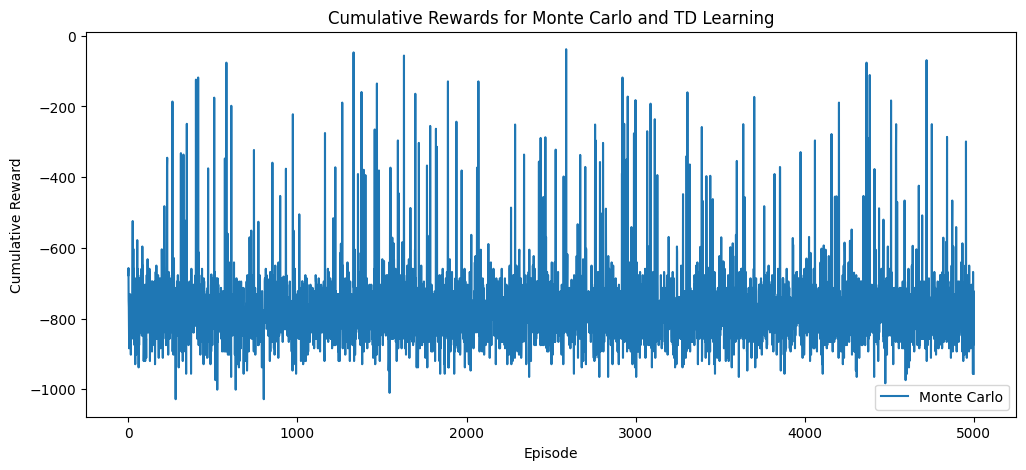

In [6]:
plt.figure(figsize=(12,5))
plt.plot(range(5000), cumulative_rewards_MC, label='Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards for Monte Carlo and TD Learning')
plt.legend()
plt.show()

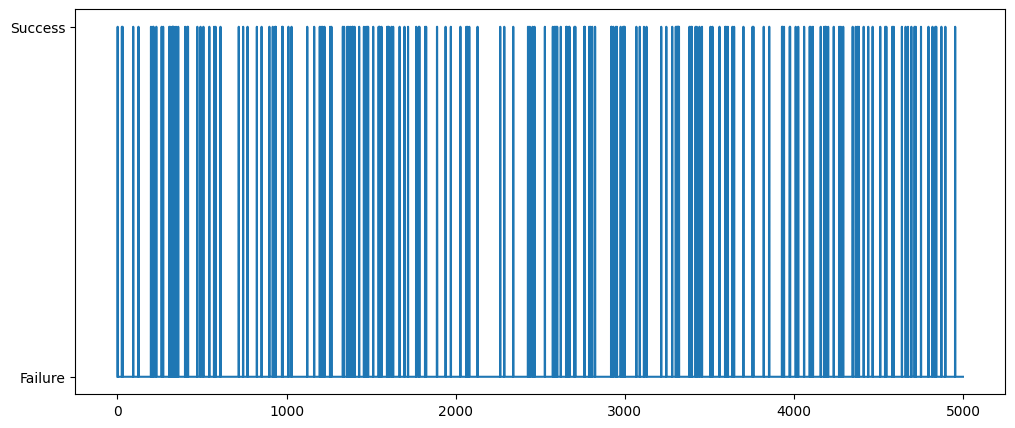

In [7]:
plt.figure(figsize=(12,5))
plt.plot(range(5000),outcomes_MC)

In [8]:
print(qtable_MC)

[[[[[   0.            0.            0.            0.
        0.           20.        ]
    [   0.          -64.31432627    0.          -51.73297278
        0.          -60.99976451]
    [   0.          -64.53899018    0.          -69.67099083
        0.          -71.23047285]
    [   0.          -45.40802731    0.          -57.80682662
        0.          -59.32053703]]

   [[   0.          -64.43554894    0.          -66.27075165
      -71.52776691  -82.62345359]
    [   0.            0.            0.            0.
        0.            0.        ]
    [   0.          -72.82347724    0.          -69.59826227
     -105.87316897  -58.34933434]
    [   0.          -80.09782098    0.          -66.79065695
      -83.52959679  -70.74761657]]

   [[   0.          -88.39480681    0.          -72.97855841
      -88.26985308  -92.23285031]
    [   0.          -73.30061961    0.          -73.00419574
      -83.29315863  -79.26447951]
    [   0.            0.            0.            0.
        0

In [9]:
episode_TD=5000
alpha_TD=0.5
gamma_TD=0.9
epsilon_TD=0.1

cumulative_rewards_TD = np.zeros(episode_TD)

In [10]:
outcomes_TD = []
def decoder(state):
        destination=int(state%4)
        state=(state-destination)/4
        passenger_location = int(state % 5)
        state=(state-passenger_location)/5    
        taxi_col =int(state % 5)
        taxi_row=int((state-taxi_col)/5)    
        return taxi_row, taxi_col, passenger_location, destination
    
for i in range(episode_MC):
    state=env.reset()
    done= False
    state=state[0]
    curr_outcome="Failure"
    outcomes_TD.append(curr_outcome)
    
    while not done:
        taxi_row, taxi_col, passenger_location, destination = decoder(state)

        if np.random.uniform(0,1) < epsilon_TD:
            action= env.action_space.sample()
        elif np.max(qtable_TD[taxi_row, taxi_col, passenger_location, destination]) > 0 :
            action = np.argmax(qtable_TD[taxi_row, taxi_col, passenger_location, destination])
        else:
            action = env.action_space.sample()
        
        new_state,reward,terminated,truncated,info=env.step(action)    
        new_taxi_row, new_taxi_col, new_passenger_location, new_destination = decoder(new_state)

        done = truncated or terminated
        qtable_TD[taxi_row, taxi_col, passenger_location, destination,action] += alpha_TD * (reward + gamma_TD * np.max(qtable_TD[new_taxi_row, new_taxi_col, new_passenger_location, new_destination]) - qtable_TD[taxi_row, taxi_col, passenger_location, destination,action])
        state = new_state
        cumulative_rewards_TD[i] += reward
        
        if reward==20:
            outcomes_TD[-1]= "Success"



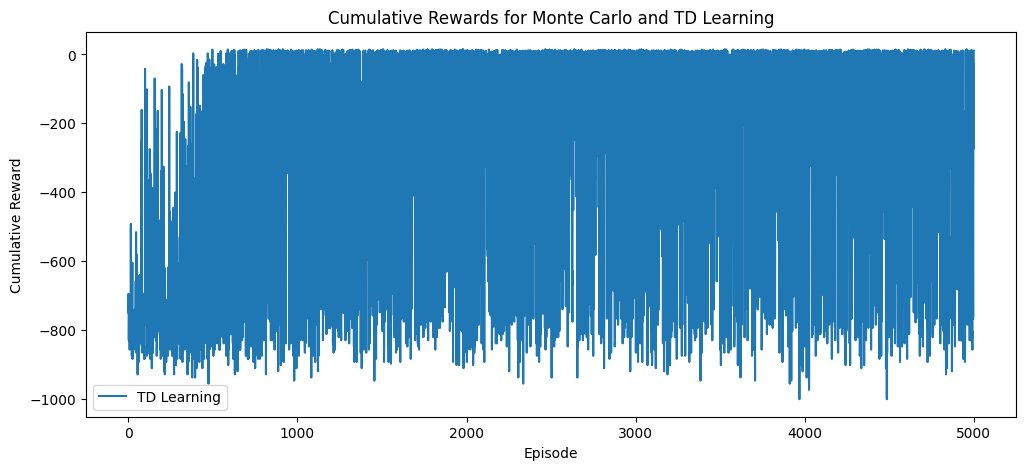

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(5000), cumulative_rewards_TD, label='TD Learning')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards for Monte Carlo and TD Learning')
plt.legend()
plt.show()

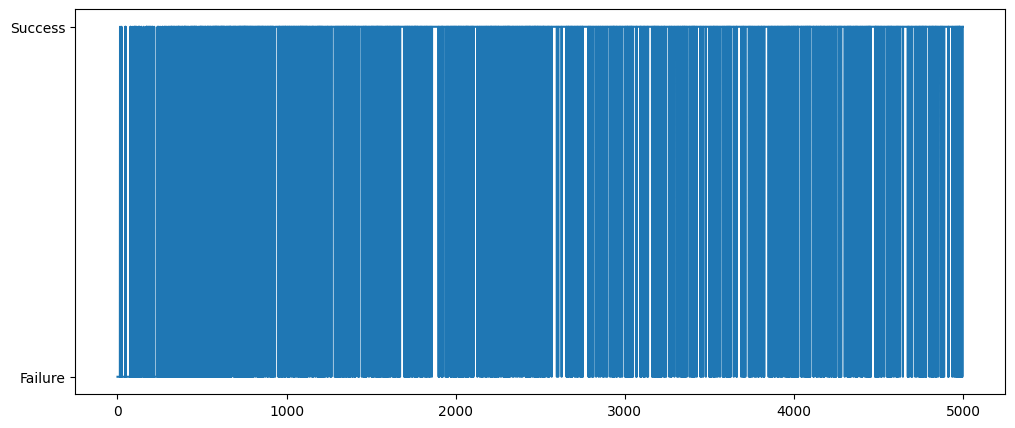

In [12]:
plt.figure(figsize=(12,5))
plt.plot(range(5000),outcomes_TD)

In [13]:
print(qtable_TD)

[[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [-1.30591391e+00  4.47425090e-01 -1.00599801e+00  9.34768129e-02
      1.62261467e+00 -8.59526622e+00]
    [ 4.33121706e+00  5.78667414e+00  4.34292857e+00  5.93479288e+00
      7.71470000e+00 -3.09594098e+00]
    [ 3.75307044e-01  1.52824313e+00  2.04877623e-01  1.55719282e+00
      2.91401630e+00 -7.38376043e+00]]

   [[-4.99684549e+00 -5.49716094e+00 -4.99684549e+00 -5.49716094e+00
     -1.44971609e+01 -1.44971609e+01]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [-4.99684549e+00 -5.49716094e+00 -4.99684549e+00 -5.49716094e+00
     -1.44971609e+01 -1.44971609e+01]
    [-3.13696226e+00 -3.82326604e+00 -3.13696226e+00 -3.82326604e+00
     -1.28232660e+01 -1.28232660e+01]]

   [[ 1.62261420e+00 -2.28786240e+00 -2.59589793e+00 -1.43655806e+00
     -1.03718223e+01 -1.12129677e+01]
    [-2.37440252e+00 -3.13696226e

In [14]:
import json
qtable_MC_Taxi = qtable_MC.tolist()  # Convert numpy array to a nested Python list

# Save the Q-table or Q-values to a JSON file
with open('qtable_MC_Taxi_5D.json', 'w') as f:
    json.dump(qtable_MC_Taxi, f)


In [15]:
import json
qtable_TD_Taxi = qtable_TD.tolist()  # Convert numpy array to a nested Python list

# Save the Q-table or Q-values to a JSON file
with open('qtable_TD_Taxi_5D.json', 'w') as f:
    json.dump(qtable_TD_Taxi, f)